# Compare the dv/v and strain to estimate the sensitivity

We compare the dv/v and strain to estimate the sensitivity of velocity to the strain.
We dumped the linear regressions for the plotting in next notebook.

2023.5.5 Kurama Okubo

- 2023.5.28 update for strain components
- 2023.6.27 update for the modification of annotation with slopes and for adding the mean values.
- 2023.7.13 update for compiling the linear regression with axial strain and remove the plotting part.


In [1]:
import datetime
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import h5py
import glob
import matplotlib as mpl
import pickle
import matplotlib.dates as dates
import seaborn as sns
from scipy import stats

import shutil
from tqdm import tqdm

from MCMC_func import * # use computing the model dv/v
import seaborn as sns 

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True


In [2]:
output_datadir = "../data"

if not os.path.exists(output_datadir):
    os.makedirs(output_datadir)

In [3]:
# read dvv data from the csv
modelcase = "wlin"

df_dvvforstrain_all = pd.read_csv(output_datadir+f"/dvvforstraincomparison_{modelcase}.csv", index_col=0)

In [4]:
df_dvvforstrain_all

,stationpair,dvvmethod,dvv_data,err_data,dvv_data_modelremoved
2002-01-16,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-01-31,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-02-15,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-03-02,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-03-17,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
...,...,...,...,...,...
2022-04-01,BP.VCAB-BP.VCAB,mwcs,0.036432,0.000001,0.064128
2022-04-16,BP.VCAB-BP.VCAB,mwcs,0.054801,0.000002,0.081709
2022-05-01,BP.VCAB-BP.VCAB,mwcs,0.037922,0.000002,0.064358
2022-05-16,BP.VCAB-BP.VCAB,mwcs,0.046758,0.000002,0.072758


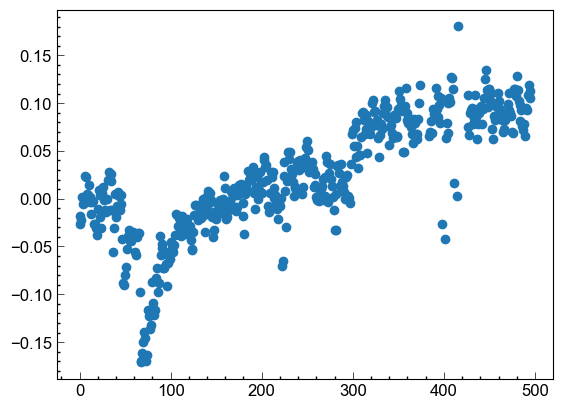

In [5]:
# df_dvvforstrain_all[]
df_tmp = df_dvvforstrain_all[(df_dvvforstrain_all["stationpair"]=="BP.VCAB-BP.VCAB") & (df_dvvforstrain_all["dvvmethod"]=="stretching")]
plt.plot(df_tmp["dvv_data_modelremoved"].values, "o")
# plt.xlim([300, 400])

In [6]:
stationpair_list = list(np.unique(df_dvvforstrain_all.stationpair))
# remove the unstable stations in dv/v 
stationpair_list.remove("BP.GHIB-BP.GHIB")
stationpair_list.remove("BP.JCSB-BP.JCSB")
stationpair_list.remove("BP.VARB-BP.VARB")

In [7]:
stationpair_list

['BP.CCRB-BP.CCRB',
 'BP.EADB-BP.EADB',
 'BP.LCCB-BP.LCCB',
 'BP.MMNB-BP.MMNB',
 'BP.SCYB-BP.SCYB',
 'BP.SMNB-BP.SMNB',
 'BP.VCAB-BP.VCAB']

In [8]:
# read strain data
df_straintimeseries_all = pd.read_csv("../data/BP_strain_timeseries_rotatedaxialstrain.csv", index_col=0)

In [9]:
# Parse the rotated angles
rotation_angles = []
for column in df_straintimeseries_all.columns:
    if column.split("_")[-1][0] == "E":
        rotation_angles.append(float(column.split("_")[-1].split("E")[-1]))
# rotation_angles

In [10]:
df_straintimeseries_all

,year,doy,datavalid_flag,BPstation,Decimal_time,waverage_dilation,waverage_maxshear,waverage_E0,waverage_E5,waverage_E10,...,waverage_E135,waverage_E140,waverage_E145,waverage_E150,waverage_E155,waverage_E160,waverage_E165,waverage_E170,waverage_E175,waverage_E180
0,2009,9,True,CCRB,2009.0260,-0.012396,0.108474,-0.021220,-0.017167,-0.012780,...,-0.028225,-0.030499,-0.032034,-0.032785,-0.032728,-0.031864,-0.030221,-0.027848,-0.024817,-0.021220
0,2009,99,True,CCRB,2009.2726,-0.046978,0.322582,0.128871,0.116221,0.099326,...,0.036029,0.061582,0.084550,0.104235,0.120040,0.131483,0.138218,0.140039,0.136892,0.128871
0,2010,4,True,CCRB,2010.0123,0.138528,0.929938,0.686700,0.660037,0.615423,...,0.168792,0.274497,0.373966,0.464176,0.542387,0.606223,0.653743,0.683505,0.694603,0.686700
0,2010,94,True,CCRB,2010.2589,0.142533,0.946208,0.844888,0.797056,0.727172,...,0.279036,0.410217,0.531100,0.638011,0.727701,0.797447,0.845127,0.869294,0.869214,0.844888
0,2010,274,True,CCRB,2010.7521,0.442912,1.407029,1.313365,1.272114,1.198939,...,0.363481,0.550932,0.728371,0.890408,1.032119,1.149199,1.238090,1.296090,1.321439,1.313365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2019,317,True,VCAB,2019.8699,1.596502,6.036383,5.936539,5.621707,5.160316,...,2.161757,3.033297,3.836925,4.548226,5.145585,5.610853,5.929892,6.093009,6.095247,5.936539
0,2020,222,True,VCAB,2020.6079,1.649101,6.761228,6.368677,6.033173,5.539407,...,2.271597,3.212341,4.080533,4.849793,5.496749,6.001742,6.349429,6.529245,6.535727,6.368677
0,2020,312,True,VCAB,2020.8538,0.566609,5.970122,5.235857,4.955578,4.533333,...,1.464079,2.306142,3.086742,3.782161,4.371270,4.836167,5.162728,5.341030,5.365656,5.235857
0,2021,36,True,VCAB,2021.1000,0.682289,6.099361,5.415781,5.128089,4.694948,...,1.553925,2.416701,3.216413,3.928761,4.532102,5.008102,5.342299,5.524538,5.549283,5.415781


In [11]:
stationpair = stationpair_list[0]
station = stationpair.split("-")[0].split(".")[-1]

<AxesSubplot:xlabel='Decimal_time'>

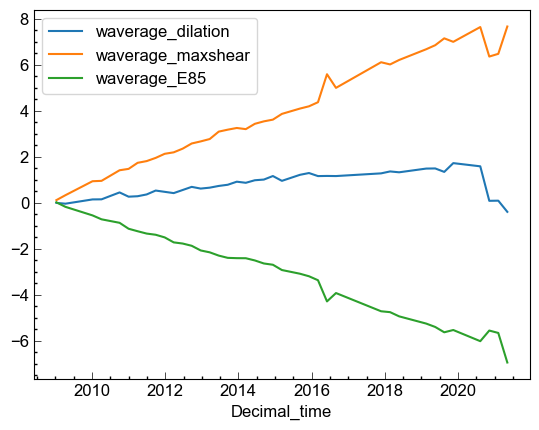

In [12]:
df_straintimeseries_all[df_straintimeseries_all["BPstation"]==station].plot(x="Decimal_time", y=["waverage_dilation", "waverage_maxshear", "waverage_E85"])

In [13]:
df_straintimeseries_all[df_straintimeseries_all["BPstation"]==station].head()

,year,doy,datavalid_flag,BPstation,Decimal_time,waverage_dilation,waverage_maxshear,waverage_E0,waverage_E5,waverage_E10,...,waverage_E135,waverage_E140,waverage_E145,waverage_E150,waverage_E155,waverage_E160,waverage_E165,waverage_E170,waverage_E175,waverage_E180
0,2009,9,True,CCRB,2009.0260,-0.012396,0.108474,-0.021220,-0.017167,-0.012780,...,-0.028225,-0.030499,-0.032034,-0.032785,-0.032728,-0.031864,-0.030221,-0.027848,-0.024817,-0.021220
0,2009,99,True,CCRB,2009.2726,-0.046978,0.322582,0.128871,0.116221,0.099326,...,0.036029,0.061582,0.084550,0.104235,0.120040,0.131483,0.138218,0.140039,0.136892,0.128871
0,2010,4,True,CCRB,2010.0123,0.138528,0.929938,0.686700,0.660037,0.615423,...,0.168792,0.274497,0.373966,0.464176,0.542387,0.606223,0.653743,0.683505,0.694603,0.686700
0,2010,94,True,CCRB,2010.2589,0.142533,0.946208,0.844888,0.797056,0.727172,...,0.279036,0.410217,0.531100,0.638011,0.727701,0.797447,0.845127,0.869294,0.869214,0.844888
0,2010,274,True,CCRB,2010.7521,0.442912,1.407029,1.313365,1.272114,1.198939,...,0.363481,0.550932,0.728371,0.890408,1.032119,1.149199,1.238090,1.296090,1.321439,1.313365


In [14]:
# Clip the strain data untile 2020 due to the missing of many GPS stations after that.
df_straintimeseries_all = df_straintimeseries_all[df_straintimeseries_all["year"] < 2020]

tvec_strain = np.zeros(len(df_straintimeseries_all), datetime.datetime)
icount=0
for i, row in df_straintimeseries_all.iterrows():
    tvec_strain[icount] = datetime.datetime(row.year,1,1) + datetime.timedelta(row.doy)
    icount = icount+1
    
df_straintimeseries_all.head()

,year,doy,datavalid_flag,BPstation,Decimal_time,waverage_dilation,waverage_maxshear,waverage_E0,waverage_E5,waverage_E10,...,waverage_E135,waverage_E140,waverage_E145,waverage_E150,waverage_E155,waverage_E160,waverage_E165,waverage_E170,waverage_E175,waverage_E180
0,2009,9,True,CCRB,2009.0260,-0.012396,0.108474,-0.021220,-0.017167,-0.012780,...,-0.028225,-0.030499,-0.032034,-0.032785,-0.032728,-0.031864,-0.030221,-0.027848,-0.024817,-0.021220
0,2009,99,True,CCRB,2009.2726,-0.046978,0.322582,0.128871,0.116221,0.099326,...,0.036029,0.061582,0.084550,0.104235,0.120040,0.131483,0.138218,0.140039,0.136892,0.128871
0,2010,4,True,CCRB,2010.0123,0.138528,0.929938,0.686700,0.660037,0.615423,...,0.168792,0.274497,0.373966,0.464176,0.542387,0.606223,0.653743,0.683505,0.694603,0.686700
0,2010,94,True,CCRB,2010.2589,0.142533,0.946208,0.844888,0.797056,0.727172,...,0.279036,0.410217,0.531100,0.638011,0.727701,0.797447,0.845127,0.869294,0.869214,0.844888
0,2010,274,True,CCRB,2010.7521,0.442912,1.407029,1.313365,1.272114,1.198939,...,0.363481,0.550932,0.728371,0.890408,1.032119,1.149199,1.238090,1.296090,1.321439,1.313365


# Comparison between strain and dvv

The `dvvdata_modelfilt` is the dv/v time history after removal of precipitation, teperature and offset around 2009.

Workflow:
1. loop with dvv method, station and date of strain
2. find the corresponding dvvdata_modelfilt
3. store the data into dataframe
4. compute linear regression


In [15]:
np.unique(df_straintimeseries_all["BPstation"])

array(['CCRB', 'EADB', 'FROB', 'GHIB', 'JCNB', 'JCSB', 'LCCB', 'MMNB',
       'RMNB', 'SCYB', 'SMNB', 'VARB', 'VCAB'], dtype=object)

In [16]:
dvvmethod = "stretching"
stationpair = stationpair_list[0]
station = stationpair.split("-")[0].split(".")[-1]

df_strainstation = df_straintimeseries_all[df_straintimeseries_all["BPstation"]==station]
df_dvvtmp = df_dvvforstrain_all[(df_dvvforstrain_all["dvvmethod"] == dvvmethod) & (df_dvvforstrain_all["stationpair"] == stationpair)]

In [17]:
df_dvvtmp

,stationpair,dvvmethod,dvv_data,err_data,dvv_data_modelremoved
2002-01-16,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-01-31,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-02-15,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-03-02,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-03-17,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
...,...,...,...,...,...
2022-04-01,BP.CCRB-BP.CCRB,stretching,0.012785,0.006207,0.066214
2022-04-16,BP.CCRB-BP.CCRB,stretching,0.003228,0.006312,0.055381
2022-05-01,BP.CCRB-BP.CCRB,stretching,-0.001091,0.007989,0.049831
2022-05-16,BP.CCRB-BP.CCRB,stretching,0.000124,0.007783,0.050319


In [18]:
columns=["dvvmethod", "t", "station", "dvv", "dilation", "maxshear"]

print(f"Rotation angles: {rotation_angles}")
for strain_theta in rotation_angles:
    columns.append(f"E{int(strain_theta):d}")
    
print(columns)

Rotation angles: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0]
['dvvmethod', 't', 'station', 'dvv', 'dilation', 'maxshear', 'E0', 'E5', 'E10', 'E15', 'E20', 'E25', 'E30', 'E35', 'E40', 'E45', 'E50', 'E55', 'E60', 'E65', 'E70', 'E75', 'E80', 'E85', 'E90', 'E95', 'E100', 'E105', 'E110', 'E115', 'E120', 'E125', 'E130', 'E135', 'E140', 'E145', 'E150', 'E155', 'E160', 'E165', 'E170', 'E175', 'E180']


In [19]:
df_dvvstrain_all = pd.DataFrame(columns=columns)
df_dvvstrain_all

,dvvmethod,t,station,dvv,dilation,maxshear,E0,E5,E10,E15,...,E135,E140,E145,E150,E155,E160,E165,E170,E175,E180


In [20]:
df_strainstation

,year,doy,datavalid_flag,BPstation,Decimal_time,waverage_dilation,waverage_maxshear,waverage_E0,waverage_E5,waverage_E10,...,waverage_E135,waverage_E140,waverage_E145,waverage_E150,waverage_E155,waverage_E160,waverage_E165,waverage_E170,waverage_E175,waverage_E180
0,2009,9,True,CCRB,2009.0260,-0.012396,0.108474,-0.021220,-0.017167,-0.012780,...,-0.028225,-0.030499,-0.032034,-0.032785,-0.032728,-0.031864,-0.030221,-0.027848,-0.024817,-0.021220
0,2009,99,True,CCRB,2009.2726,-0.046978,0.322582,0.128871,0.116221,0.099326,...,0.036029,0.061582,0.084550,0.104235,0.120040,0.131483,0.138218,0.140039,0.136892,0.128871
0,2010,4,True,CCRB,2010.0123,0.138528,0.929938,0.686700,0.660037,0.615423,...,0.168792,0.274497,0.373966,0.464176,0.542387,0.606223,0.653743,0.683505,0.694603,0.686700
0,2010,94,True,CCRB,2010.2589,0.142533,0.946208,0.844888,0.797056,0.727172,...,0.279036,0.410217,0.531100,0.638011,0.727701,0.797447,0.845127,0.869294,0.869214,0.844888
0,2010,274,True,CCRB,2010.7521,0.442912,1.407029,1.313365,1.272114,1.198939,...,0.363481,0.550932,0.728371,0.890408,1.032119,1.149199,1.238090,1.296090,1.321439,1.313365
0,2010,364,True,CCRB,2010.9986,0.257949,1.467115,1.356705,1.281459,1.171194,...,0.454890,0.663132,0.855144,1.025091,1.167811,1.278966,1.355178,1.394134,1.394648,1.356705
0,2011,89,True,CCRB,2011.2452,0.277479,1.730705,1.479982,1.396732,1.275260,...,0.500809,0.728213,0.937706,1.122922,1.278235,1.398925,1.481324,1.522930,1.522478,1.479982
0,2011,179,True,CCRB,2011.4918,0.355288,1.805497,1.652721,1.559013,1.423332,...,0.588236,0.838143,1.067980,1.270766,1.440337,1.571542,1.660394,1.704194,1.701610,1.652721
0,2011,269,True,CCRB,2011.7384,0.524406,1.944625,1.882159,1.792792,1.656920,...,0.635116,0.910753,1.166684,1.395133,1.589158,1.742865,1.851582,1.912007,1.922304,1.882159
0,2011,359,True,CCRB,2011.9849,0.468814,2.122452,1.941635,1.849670,1.708626,...,0.614648,0.905328,1.175623,1.417319,1.623073,1.786634,1.903030,1.968726,1.981726,1.941635


In [21]:
df_dvvstrain_all = pd.DataFrame(columns=columns)

for dvvmethod in [ "stretching", "mwcs"]:
#     dvvmethod = "stretching"

    for stationpair in stationpair_list:
        station = stationpair.split("-")[0].split(".")[-1]
        # select the data with dvv method and station
        df_strainstation = df_straintimeseries_all[df_straintimeseries_all["BPstation"]==station]
        df_dvvtmp = df_dvvforstrain_all[(df_dvvforstrain_all["dvvmethod"] == dvvmethod) & (df_dvvforstrain_all["stationpair"] == stationpair)]

        for i, row in df_strainstation.iterrows():
            
            # convert from doy to datetime
            snap_date = datetime.datetime(row.year, 1, 1) + datetime.timedelta(float(row.doy-1))
            
            # find the datetime snapshot in dvv
            df_dvvstation = df_dvvtmp[(pd.to_datetime(df_dvvtmp.index) == snap_date)]

            if df_dvvstation.empty:
                print(f"{station} {snap_date} is empty.")
                continue;

            # check if dv/v is unique
            assert len(df_dvvstation) == 1
            

            # store the dvv and corresponding strain into dataframe
            data_dvvandstrain = dict(dvvmethod=[dvvmethod], t=[snap_date], station=[station], dvv=[df_dvvstation.dvv_data_modelremoved.values[0]], 
                                                dilation=[row.waverage_dilation], maxshear=[row.waverage_maxshear])
                 
            for strain_theta_deg in rotation_angles:
                data_dvvandstrain[f"E{int(strain_theta_deg):d}"] = row[f"waverage_E{int(strain_theta_deg):d}"]
                
            # append to the master dataframe
            df_dvvstrain_all = pd.concat([df_dvvstrain_all, pd.DataFrame.from_dict(data_dvvandstrain)])

In [22]:
df_dvvstrain_all

,dvvmethod,t,station,dvv,dilation,maxshear,E0,E5,E10,E15,...,E135,E140,E145,E150,E155,E160,E165,E170,E175,E180
0,stretching,2009-01-09,CCRB,-0.062233,-0.012396,0.108474,-0.021220,-0.017167,-0.012780,-0.008194,...,-0.028225,-0.030499,-0.032034,-0.032785,-0.032728,-0.031864,-0.030221,-0.027848,-0.024817,-0.021220
0,stretching,2009-04-09,CCRB,0.006027,-0.046978,0.322582,0.128871,0.116221,0.099326,0.078700,...,0.036029,0.061582,0.084550,0.104235,0.120040,0.131483,0.138218,0.140039,0.136892,0.128871
0,stretching,2010-01-04,CCRB,0.043405,0.138528,0.929938,0.686700,0.660037,0.615423,0.554215,...,0.168792,0.274497,0.373966,0.464176,0.542387,0.606223,0.653743,0.683505,0.694603,0.686700
0,stretching,2010-04-04,CCRB,NaN,0.142533,0.946208,0.844888,0.797056,0.727172,0.637358,...,0.279036,0.410217,0.531100,0.638011,0.727701,0.797447,0.845127,0.869294,0.869214,0.844888
0,stretching,2010-10-01,CCRB,-0.004792,0.442912,1.407029,1.313365,1.272114,1.198939,1.096064,...,0.363481,0.550932,0.728371,0.890408,1.032119,1.149199,1.238090,1.296090,1.321439,1.313365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,mwcs,2018-05-22,VCAB,NaN,1.297152,5.384271,5.143297,4.848885,4.426849,3.890011,...,1.950791,2.711508,3.409543,4.023688,4.535282,4.928780,5.192226,5.317616,5.301140,5.143297
0,mwcs,2019-02-16,VCAB,0.213481,1.366287,5.767805,5.476843,5.152356,4.692075,4.109984,...,2.132393,2.942793,3.684534,4.335080,4.874663,5.286890,5.559234,5.683420,5.655675,5.476843
0,mwcs,2019-05-17,VCAB,NaN,1.452667,5.923226,5.664871,5.342357,4.879588,4.290624,...,2.151549,2.987465,3.754678,4.429875,4.992543,5.425584,5.715840,5.854493,5.837330,5.664871
0,mwcs,2019-08-15,VCAB,0.069851,1.447006,6.395531,5.856034,5.562164,5.121274,4.546760,...,1.966793,2.839159,3.647242,4.366489,4.975045,5.454421,5.790050,5.971735,5.993954,5.856034


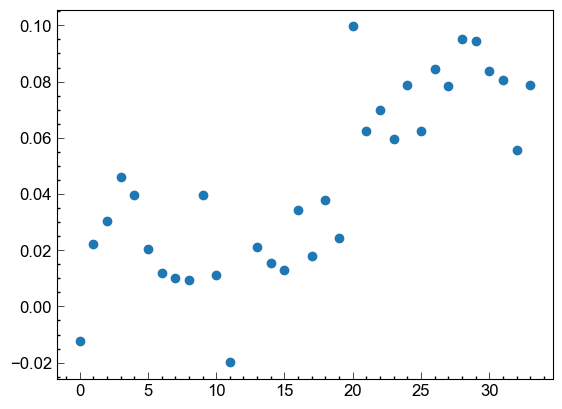

In [23]:
# df_dvvforstrain_all[]
df_tmp = df_dvvstrain_all[(df_dvvstrain_all["station"]=="EADB") & (df_dvvstrain_all["dvvmethod"]=="stretching")]
plt.plot(df_tmp["dvv"].values, "o")

In [24]:
stationlist = np.unique(df_dvvstrain_all["station"])
stationlist

array(['CCRB', 'EADB', 'LCCB', 'MMNB', 'SCYB', 'SMNB', 'VCAB'],
      dtype=object)

# Compute linear regression to estimate sensitivity
We compute the linear regression associated with each station to estimate the sensitivity to the dilation and max shear.
Note that we rescale the dvv and strain as  dvv [%]-> [1] , strain [µε] -> [ε].

We first compute the linear regression for each station pair to see if there is outliers. We then compute the linear regression for all stations in the station list.

## Linear regression with each station


In [25]:
linregress_columns = ["dvvmethod", "station"]

for comp in ["dilation", "maxshear"]:
    linregress_columns.append(f"{comp}_slope")
    linregress_columns.append(f"{comp}_intercept")
    linregress_columns.append(f"{comp}_stderr")
    
for strain_theta_deg in rotation_angles:
    comp = f"E{int(strain_theta_deg):d}"
    linregress_columns.append(f"{comp}_slope")
    linregress_columns.append(f"{comp}_intercept")
    linregress_columns.append(f"{comp}_stderr")
    
df_linregress_st = pd.DataFrame(columns=linregress_columns)
df_linregress_st

,dvvmethod,station,dilation_slope,dilation_intercept,dilation_stderr,maxshear_slope,maxshear_intercept,maxshear_stderr,E0_slope,E0_intercept,...,E165_stderr,E170_slope,E170_intercept,E170_stderr,E175_slope,E175_intercept,E175_stderr,E180_slope,E180_intercept,E180_stderr


In [26]:
df_linregress_st = pd.DataFrame(columns=linregress_columns)

for dvvmethod in ["stretching", "mwcs"]:
    for station in stationlist:
        #station = stationlist[0]
        df_dvvstrain_st= df_dvvstrain_all[(df_dvvstrain_all["dvvmethod"]==dvvmethod) & (df_dvvstrain_all["station"] == station)]
        
        mask = ~np.isnan(df_dvvstrain_st.dilation) & ~np.isnan(df_dvvstrain_st.dvv)
        
        # scale values dvv [%]-> absolute , strain [µε] -> [ε]
        res_dilation = stats.linregress(df_dvvstrain_st.dilation[mask]*1e-6, df_dvvstrain_st.dvv[mask]*1e-2)
        res_maxshear = stats.linregress(df_dvvstrain_st.maxshear[mask]*1e-6, df_dvvstrain_st.dvv[mask]*1e-2)

        # compute for strain components
        res_comp_dict = dict()
        for strain_theta_deg in rotation_angles:
            comp = f"E{int(strain_theta_deg):d}"
            res_comp_dict[comp] = stats.linregress(df_dvvstrain_st[comp][mask]*1e-6, df_dvvstrain_st.dvv[mask]*1e-2)
            
        # store to the dataframe
        linregress_data = dict(dvvmethod=[dvvmethod], station=[station], dilation_slope=[res_dilation.slope], dilation_intercept=[res_dilation.intercept],
                              dilation_stderr=[res_dilation.stderr], maxshear_slope=[res_maxshear.slope], maxshear_intercept=[res_maxshear.intercept], maxshear_stderr=[res_maxshear.stderr])
        
        for strain_theta_deg in rotation_angles:
            comp = f"E{int(strain_theta_deg):d}"
            linregress_data[f"{comp}_slope"] = [res_comp_dict[comp].slope]
            linregress_data[f"{comp}_intercept"] = [res_comp_dict[comp].intercept]
            linregress_data[f"{comp}_stderr"] = [res_comp_dict[comp].stderr]
        
        df_linregress_st = pd.concat([df_linregress_st, pd.DataFrame.from_dict(linregress_data)])
                

In [27]:
res_maxshear

LinregressResult(slope=139.4907662198659, intercept=-4.50573865985123e-05, rvalue=0.5734913090796997, pvalue=0.00272592962625472, stderr=41.54806648086728, intercept_stderr=0.00014084107313998043)

In [28]:
df_linregress_st

,dvvmethod,station,dilation_slope,dilation_intercept,dilation_stderr,maxshear_slope,maxshear_intercept,maxshear_stderr,E0_slope,E0_intercept,...,E165_stderr,E170_slope,E170_intercept,E170_stderr,E175_slope,E175_intercept,E175_stderr,E180_slope,E180_intercept,E180_stderr
0,stretching,CCRB,555.276560,-0.000133,75.639768,128.996482,-0.000126,17.753839,128.369017,-0.000115,...,17.595463,126.235674,-0.000114,17.067692,125.573402,-0.000115,17.015303,128.369017,-0.000115,17.431159
0,stretching,EADB,-1590.815481,0.000270,624.348271,102.126366,0.000013,12.091936,124.668468,0.000025,...,15.801800,126.293880,0.000025,14.961703,123.548947,0.000025,14.632421,124.668468,0.000025,14.760024
0,stretching,LCCB,483.507672,0.000021,119.125136,97.508197,0.000049,24.127468,97.439165,0.000053,...,24.533569,96.776904,0.000050,23.713162,95.767704,0.000052,23.571064,97.439165,0.000053,24.087428
0,stretching,MMNB,646.090776,-0.000312,71.212702,127.459358,-0.000318,11.114877,131.282007,-0.000303,...,11.867118,129.636930,-0.000303,11.491211,128.669089,-0.000303,11.449447,131.282007,-0.000303,11.735893
0,stretching,SCYB,32.489479,0.000384,262.397177,78.935061,0.000005,11.220530,82.555522,0.000010,...,12.912387,84.450231,0.000007,12.201351,82.241727,0.000008,11.907640,82.555522,0.000010,11.983418
0,stretching,SMNB,683.679087,0.000071,238.790073,84.144898,-0.000026,23.042151,86.631597,-0.000014,...,25.015460,87.245451,-0.000014,23.909870,85.684740,-0.000014,23.551195,86.631597,-0.000014,23.885284
0,stretching,VCAB,609.976732,-0.000063,147.056959,154.312749,-0.000075,35.742822,157.257824,-0.000050,...,36.701819,154.314339,-0.000051,35.680512,153.721862,-0.000050,35.639299,157.257824,-0.000050,36.572537
0,mwcs,CCRB,237.529965,-0.000003,54.828728,53.021403,0.000007,13.124055,53.184896,0.000010,...,13.073081,52.258222,0.000011,12.665685,52.002164,0.000010,12.611831,53.184896,0.000010,12.904193
0,mwcs,EADB,-901.526007,0.000193,700.242884,57.340048,0.000050,20.842305,69.825892,0.000058,...,27.210270,70.904755,0.000057,25.777270,69.280594,0.000057,25.223363,69.825892,0.000058,25.457817
0,mwcs,LCCB,416.260211,-0.000072,120.770254,79.604732,-0.000028,24.851561,80.349243,-0.000028,...,25.295937,79.387974,-0.000029,24.418596,78.757958,-0.000029,24.241951,80.349243,-0.000028,24.741282


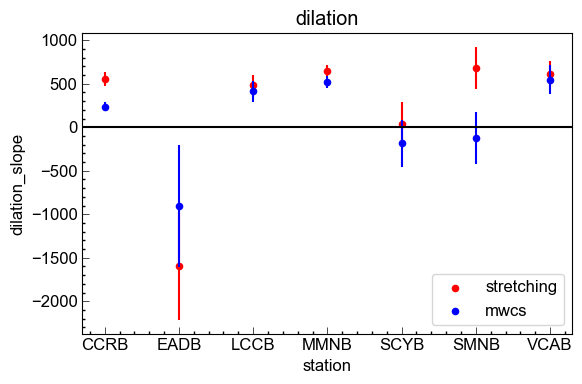

In [29]:
# check the slope and err if there is outliers
comp = "dilation"
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df_linregress_st[df_linregress_st["dvvmethod"]=="stretching"].plot.scatter(x="station", y=f"{comp}_slope", yerr=f"{comp}_stderr",
                                                                             label="stretching", c="r", ax=ax)
df_linregress_st[df_linregress_st["dvvmethod"]=="mwcs"].plot.scatter(x="station", y=f"{comp}_slope", yerr=f"{comp}_stderr",
                                                                       label="mwcs", c="b", ax=ax)

ax.legend(loc=4)
ax.set_title(f"{comp}")
ax.axhline(0, ls="-", color="k")
plt.tight_layout()

<AxesSubplot:xlabel='Decimal_time'>

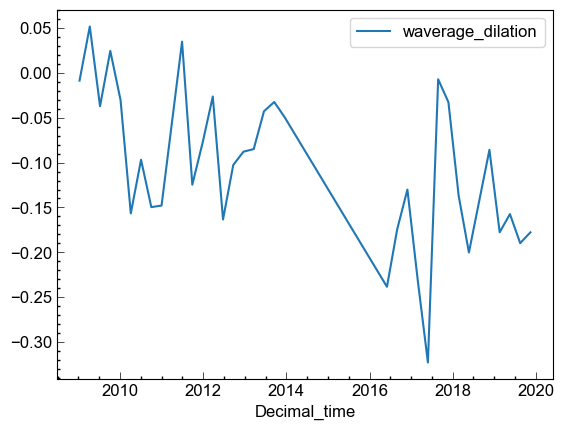

In [30]:
df_straintimeseries_all[df_straintimeseries_all["BPstation"]=="EADB"].plot(x="Decimal_time", y="waverage_dilation")

## Linear regression using all stations

We compute the sensitivity of dvv to strain and of strain to dvv indicated as `_inv`.

In [31]:
linregress_columns_all = ["dvvmethod", "station"]

for comp in ["dilation", "maxshear"]:
    linregress_columns_all.append(f"{comp}_slope")
    linregress_columns_all.append(f"{comp}_intercept")
    linregress_columns_all.append(f"{comp}_stderr")
    
    linregress_columns_all.append(f"{comp}_slope_inv")
    linregress_columns_all.append(f"{comp}_intercept_inv")
    linregress_columns_all.append(f"{comp}_stderr_inv")
    
for strain_theta_deg in rotation_angles:
    comp = f"E{int(strain_theta_deg):d}"
    linregress_columns_all.append(f"{comp}_slope")
    linregress_columns_all.append(f"{comp}_intercept")
    linregress_columns_all.append(f"{comp}_stderr")
    
    linregress_columns_all.append(f"{comp}_slope_inv")
    linregress_columns_all.append(f"{comp}_intercept_inv")
    linregress_columns_all.append(f"{comp}_stderr_inv")
    
df_linregress_all = pd.DataFrame(columns=linregress_columns_all)
df_linregress_all

,dvvmethod,station,dilation_slope,dilation_intercept,dilation_stderr,dilation_slope_inv,dilation_intercept_inv,dilation_stderr_inv,maxshear_slope,maxshear_intercept,...,E175_stderr,E175_slope_inv,E175_intercept_inv,E175_stderr_inv,E180_slope,E180_intercept,E180_stderr,E180_slope_inv,E180_intercept_inv,E180_stderr_inv


In [32]:
df_linregress_all = pd.DataFrame(columns=linregress_columns)

for dvvmethod in ["stretching", "mwcs"]:

    df_dvvstrain_method= df_dvvstrain_all[(df_dvvstrain_all["dvvmethod"]==dvvmethod)]

    mask = ~np.isnan(df_dvvstrain_method.dilation) & ~np.isnan(df_dvvstrain_method.dvv)

    # scale values dvv [%]-> absolute , strain [µε] -> [ε]
    res_comp_dict = dict()
    for comp in ["dilation", "maxshear"]:
        res_comp_dict[comp] = stats.linregress(df_dvvstrain_method[comp][mask]*1e-6, df_dvvstrain_method.dvv[mask]*1e-2)
        res_comp_dict[f"{comp}_inv"] = stats.linregress(df_dvvstrain_method.dvv[mask]*1e-2, df_dvvstrain_method[comp][mask]*1e-6)
            
    # compute for strain components
    for strain_theta_deg in rotation_angles:
        comp = f"E{int(strain_theta_deg):d}"
        res_comp_dict[comp] = stats.linregress(df_dvvstrain_method[comp][mask]*1e-6, df_dvvstrain_method.dvv[mask]*1e-2)
        res_comp_dict[f"{comp}_inv"] = stats.linregress(df_dvvstrain_method.dvv[mask]*1e-2, df_dvvstrain_method[comp][mask]*1e-6)

    # store to the dataframe
    linregress_data = dict(dvvmethod=[dvvmethod], station=[stationlist])
    
    for comp in ["dilation", "maxshear"]:
        linregress_data[f"{comp}_slope"] = [res_comp_dict[comp].slope]
        linregress_data[f"{comp}_intercept"] = [res_comp_dict[comp].intercept]
        linregress_data[f"{comp}_stderr"] = [res_comp_dict[comp].stderr]
        
        linregress_data[f"{comp}_slope_inv"] = [res_comp_dict[f"{comp}_inv"].slope]
        linregress_data[f"{comp}_intercept_inv"] = [res_comp_dict[f"{comp}_inv"].intercept]
        linregress_data[f"{comp}_stderr_inv"] = [res_comp_dict[f"{comp}_inv"].stderr]

        
    for strain_theta_deg in rotation_angles:
        comp = f"E{int(strain_theta_deg):d}"
        linregress_data[f"{comp}_slope"] = [res_comp_dict[comp].slope]
        linregress_data[f"{comp}_intercept"] = [res_comp_dict[comp].intercept]
        linregress_data[f"{comp}_stderr"] = [res_comp_dict[comp].stderr]
        linregress_data[f"{comp}_slope_inv"] = [res_comp_dict[f"{comp}_inv"].slope]
        linregress_data[f"{comp}_intercept_inv"] = [res_comp_dict[f"{comp}_inv"].intercept]
        linregress_data[f"{comp}_stderr_inv"] = [res_comp_dict[f"{comp}_inv"].stderr]
        
    df_linregress_all = pd.concat([df_linregress_all, pd.DataFrame.from_dict(linregress_data)])
                

In [33]:
df_linregress_all

,dvvmethod,station,dilation_slope,dilation_intercept,dilation_stderr,maxshear_slope,maxshear_intercept,maxshear_stderr,E0_slope,E0_intercept,...,E165_stderr_inv,E170_slope_inv,E170_intercept_inv,E170_stderr_inv,E175_slope_inv,E175_intercept_inv,E175_stderr_inv,E180_slope_inv,E180_intercept_inv,E180_stderr_inv
0,stretching,"[CCRB, EADB, LCCB, MMNB, SCYB, SMNB, VCAB]",249.790530,0.000245,41.330998,100.446172,-0.000034,7.242314,103.787205,-0.00002,...,0.000305,0.004363,0.000002,0.000319,0.004411,0.000002,0.000324,0.004333,0.000002,0.000320
0,mwcs,"[CCRB, EADB, LCCB, MMNB, SCYB, SMNB, VCAB]",206.374163,0.000182,41.255929,65.211193,0.000022,8.560107,67.839542,0.00003,...,0.000377,0.003030,0.000003,0.000395,0.003054,0.000003,0.000401,0.002992,0.000003,0.000395


In [34]:
df_linregress_all

,dvvmethod,station,dilation_slope,dilation_intercept,dilation_stderr,maxshear_slope,maxshear_intercept,maxshear_stderr,E0_slope,E0_intercept,...,E165_stderr_inv,E170_slope_inv,E170_intercept_inv,E170_stderr_inv,E175_slope_inv,E175_intercept_inv,E175_stderr_inv,E180_slope_inv,E180_intercept_inv,E180_stderr_inv
0,stretching,"[CCRB, EADB, LCCB, MMNB, SCYB, SMNB, VCAB]",249.790530,0.000245,41.330998,100.446172,-0.000034,7.242314,103.787205,-0.00002,...,0.000305,0.004363,0.000002,0.000319,0.004411,0.000002,0.000324,0.004333,0.000002,0.000320
0,mwcs,"[CCRB, EADB, LCCB, MMNB, SCYB, SMNB, VCAB]",206.374163,0.000182,41.255929,65.211193,0.000022,8.560107,67.839542,0.00003,...,0.000377,0.003030,0.000003,0.000395,0.003054,0.000003,0.000401,0.002992,0.000003,0.000395


In [35]:
df_dvvstrain_method

,dvvmethod,t,station,dvv,dilation,maxshear,E0,E5,E10,E15,...,E135,E140,E145,E150,E155,E160,E165,E170,E175,E180
0,mwcs,2009-01-09,CCRB,0.008151,-0.012396,0.108474,-0.021220,-0.017167,-0.012780,-0.008194,...,-0.028225,-0.030499,-0.032034,-0.032785,-0.032728,-0.031864,-0.030221,-0.027848,-0.024817,-0.021220
0,mwcs,2009-04-09,CCRB,0.015121,-0.046978,0.322582,0.128871,0.116221,0.099326,0.078700,...,0.036029,0.061582,0.084550,0.104235,0.120040,0.131483,0.138218,0.140039,0.136892,0.128871
0,mwcs,2010-01-04,CCRB,0.009306,0.138528,0.929938,0.686700,0.660037,0.615423,0.554215,...,0.168792,0.274497,0.373966,0.464176,0.542387,0.606223,0.653743,0.683505,0.694603,0.686700
0,mwcs,2010-04-04,CCRB,NaN,0.142533,0.946208,0.844888,0.797056,0.727172,0.637358,...,0.279036,0.410217,0.531100,0.638011,0.727701,0.797447,0.845127,0.869294,0.869214,0.844888
0,mwcs,2010-10-01,CCRB,0.015670,0.442912,1.407029,1.313365,1.272114,1.198939,1.096064,...,0.363481,0.550932,0.728371,0.890408,1.032119,1.149199,1.238090,1.296090,1.321439,1.313365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,mwcs,2018-05-22,VCAB,NaN,1.297152,5.384271,5.143297,4.848885,4.426849,3.890011,...,1.950791,2.711508,3.409543,4.023688,4.535282,4.928780,5.192226,5.317616,5.301140,5.143297
0,mwcs,2019-02-16,VCAB,0.213481,1.366287,5.767805,5.476843,5.152356,4.692075,4.109984,...,2.132393,2.942793,3.684534,4.335080,4.874663,5.286890,5.559234,5.683420,5.655675,5.476843
0,mwcs,2019-05-17,VCAB,NaN,1.452667,5.923226,5.664871,5.342357,4.879588,4.290624,...,2.151549,2.987465,3.754678,4.429875,4.992543,5.425584,5.715840,5.854493,5.837330,5.664871
0,mwcs,2019-08-15,VCAB,0.069851,1.447006,6.395531,5.856034,5.562164,5.121274,4.546760,...,1.966793,2.839159,3.647242,4.366489,4.975045,5.454421,5.790050,5.971735,5.993954,5.856034


# Save the dataframe

In [36]:
# dvv and strain comparison

df_dvvstrain_all.to_csv(output_datadir+"/comparison_dvv_strain_all.csv")

# sensitivity data
df_linregress_all.to_csv(output_datadir+"/sensitivity_linearregression_useallstation.csv")

We plot the figures in the next notebook using the dumped dataset.